# Image Caption Generation

Full credits goes to this [repo](https://github.com/ElisonSherton/Image_Captioning).

The aim of this notebook is to use a trained image-captioning model in order to generate predictions for randomly picked images.

Our tokenizer has almost 7.5k words and that would be our vocabulary i.e. all the sentences that we'll generate will have words picked from these words itself.

The model that we've trained uses a pretrained ResNet50 architecture to encode images and subsequently the sequence output is generated using an LSTM network. The architecture used for this purpose is called merge architecture.

![](https://raw.githubusercontent.com/ElisonSherton/Host_Data/master/merge_architecture.PNG)

Let's start generating captions!

In [ ]:
# import necessary libraries
import os                                                                       # To deal with filepaths and repositories
import random                                                                   # For generating random numbers or randomly selecting one out of a bunch of images

import numpy as np                                                              # Numerical Python for array, matrix operations

import matplotlib.pyplot as plt                                                 # To display images
%matplotlib inline

from keras.models import load_model, Model                                      # To load the pretrained model and to define a modified ResNet50 architecture for image encoding
from keras.preprocessing.text import Tokenizer                                  # To load vocabulary for generating words
from keras.applications.resnet import ResNet50                                  # For image encoding
from keras.applications.resnet50 import preprocess_input                        # To transform image into the format expected by ResNet50 architecture (Size, Shape, Normalization etc.)
from keras.preprocessing.image import load_img, img_to_array                    # To load image into memory and to convert image to numpy array
from keras.preprocessing.sequence import pad_sequences                          # To generate sequences of a fixed length (pad the sequence if there's less words with enough fillers)

from pickle import load                                                         # To load the tokenizer object saved on disk

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Stored Architecture

Specify the paths to the image for which you want to generate a caption, the model that you've trained and the tokenizer containing the vocabulary for that corpus of images.

In [ ]:
img_path = '/content/drive/My Drive/flicker8k-dataset/Flickr8k_Dataset/Validation'
model_path = '/content/drive/My Drive/model_10.h5'
tokenizer_path = '/content/drive/My Drive/tokenizer_vt2.pkl'

In [ ]:
# random_image = random.sample(os.listdir(img_path), 1)[0]
# img_abs_path = f'{img_path}/{random_image}'
img_abs_path = '/content/drive/My Drive/2015-Must-have-Riding-Gear.jpg'

# Define helper methods

Defining the following methods to generate and render captions for provided images.

- *get_image_features(image_path)*:   Given the path where the image is stored pass it through a ResNet50 imagenet trained model and return the features for the same

- *load_pretrained_data(model_path, tokenizer_path)*:   Given the path for model and tokenizer, extracts the same and returns model, tokenizer and maximum caption length (specified manually).

- *get_word_from_idx(idx, tokenizer)*:	Given the tokenizer and the index of a predicted	word, returns the word by hunting for the same in the tokenizer's dictionary.

- *generate_caption(model_path, image_path, tokenizer_path)*: Given the path for image, pretrained model, and tokenizer, it generates and subsequently returns a captions

- *view_img_caption_pair(model_path, image_path, tokenizer_path)*: Given the model's path, image's path and tokenizer's path it generates a caption for the provided image and displays the same with the original image.

In [ ]:
def get_image_features(img_abs_path):
  '''
  Given the path where the image is stored,
  pass it through a ResNet50 imagenet trained model and
  return the features for the same
  '''
  model = ResNet50()                                                            # Instantiate a ResNet50 model
  model.layers.pop()                                                            # Remove the last layer of pretrained ImageNet data
  Image_Feature_Generator = Model(inputs = model.inputs, outputs = model.layers[-1].output)  # Redefine the model after removing the last layer
  img = load_img(img_abs_path, target_size = (224, 224))                        # Load the image from the path and resize to (224,224) for passing it through the ResNet pretrained model
  img = img_to_array(img)                                                       # Convert the image into a numpy array
  rows, columns, channels = img.shape                                           # Extract the dimensions of the image
  img = img.reshape((1, rows, columns, channels))                               # Redefine the image dimensions in a batch format
  img = preprocess_input(img)                                                   # Preprocess the input in order to bring it in a similar format as the imagenet preprocessing steps in original ResNet architecture
  features = Image_Feature_Generator.predict(img)                               # Generate features from the image
  return features

In [ ]:
def load_pretrained_data(model_path, tokenizer_path):
  '''
  Given the path for model and tokenizer, extracts
  the same and returns model, tokenizer and maximum
  caption length (specified manually)
  '''
  model = load_model(model_path)
  tk = load(open(tokenizer_path, 'rb'))
  max_length = 22
  return (model, tk, max_length)

In [ ]:
def get_word_from_idx(idx, tokenizer):
	'''
	Given the tokenizer and the index of a predicted
	word, returns the word by hunting for the same in
	the tokenizer's dictionary
	'''
	idx_to_word = {val:key for key, val in tokenizer.word_index.items()}
	if idx in idx_to_word.keys():
		return idx_to_word[idx]
	else:
		return None

In [ ]:
def generate_caption(model_path, image_path, tokenizer_path):
  '''
  Given the path for image, pretrained model, and
  tokenizer, it generates and subsequently returns a captions
  '''
  ip_seq = 'startseq'                                                           # Seeding the caption generation with startseq
  model, tk, max_length = load_pretrained_data(model_path, tokenizer_path)      # Retrieve the model, tokenizer, max caption length from provided path
  features = get_image_features(image_path)                                     # Extract ResNet50 features corresponding to the image

  for idx in range(max_length):
    seq = tk.texts_to_sequences([ip_seq])[0]                                    # Tokenize the input using the tokenizer object loaded above
    seq = pad_sequences([seq], maxlen = max_length, padding = 'post')           # Pad the sequences to be of same length as the maximum caption length
    new_word_distribution = model.predict([features, seq], verbose = 0)         # Forward propogate the image features and caption features
    new_word_idx = np.argmax(new_word_distribution)                             # Get the index corresponding to most probable word outcome
    new_word = get_word_from_idx(new_word_idx, tk)                              # Extract the word from index generated above

    if new_word:
      if new_word != 'endseq':
        ip_seq = ip_seq + " " + new_word                                        # If the new word isn't None or endseq, then add it to the ip_seq for further caption generation
      else:
        break                                                                   # If word is 'endseq' then break
    else:
      break                                                                     # If no word is returned then break

  op_seq = " ".join([i for i in ip_seq.split(' ') if i!='startseq' and i!= 'endseq']) # Remove the words startseq and endseq from the ouput if they're present
  return op_seq

In [ ]:
# Modified on 27th Feb to only show the generated caption
def view_img_caption_pair(model_path, image_path, tokenizer_path):
  '''
  Given the model's path, image's path and tokenizer's path
  it generates a caption for the provided image and displays
  the same with the original image.
  '''
  text = generate_caption(model_path, image_path, tokenizer_path)
  im  = np.array(load_img(image_path))
  fig, ax = plt.subplots(1, 2, figsize = (10,10))

  # Display the image
  ax[0].imshow(im)
  ax[0].axis('off')
  ax[0].set_title('Image', fontsize = 15)

  # Display caption beside the image
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax[1].set_xlim([0,0.5])
  ax[1].set_ylim([0,0.5])
  ax[1].text(0, 0.45, text, transform=ax[1].transAxes, fontsize=20,
        verticalalignment='center', bbox=props)
  ax[1].axis('off');

# Generate Image Caption Pairs


102973440/102967424 [==============================] - 2s 0us/step


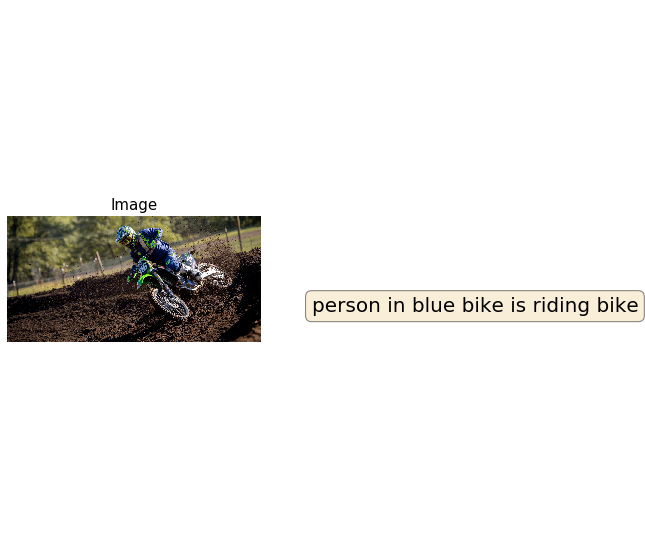

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

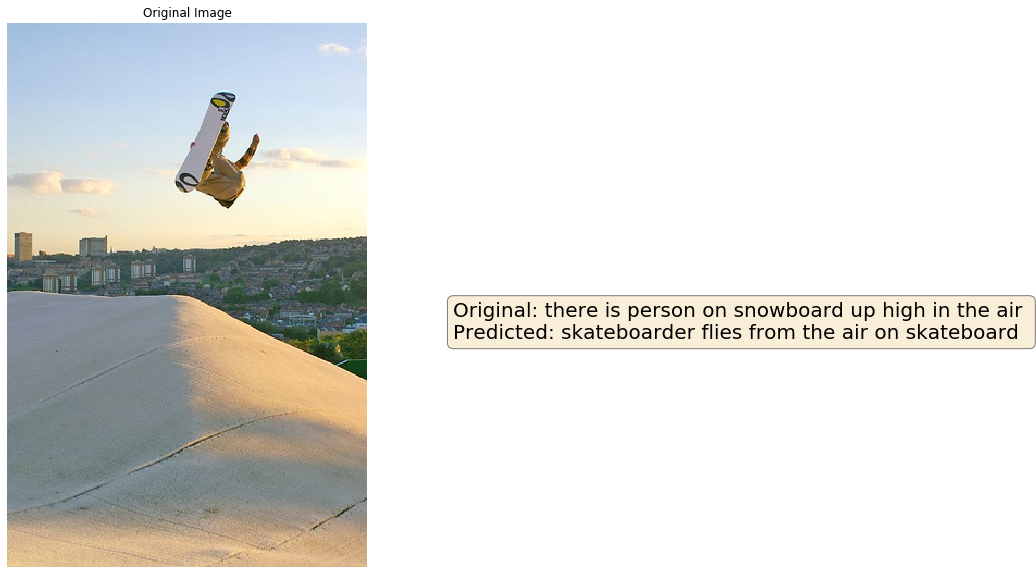

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

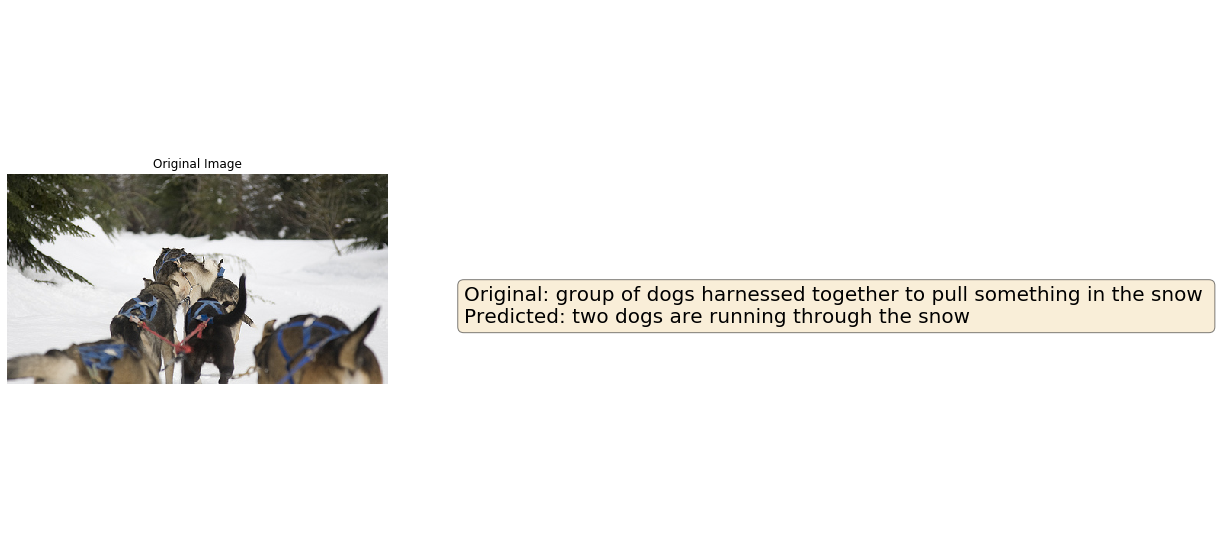

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

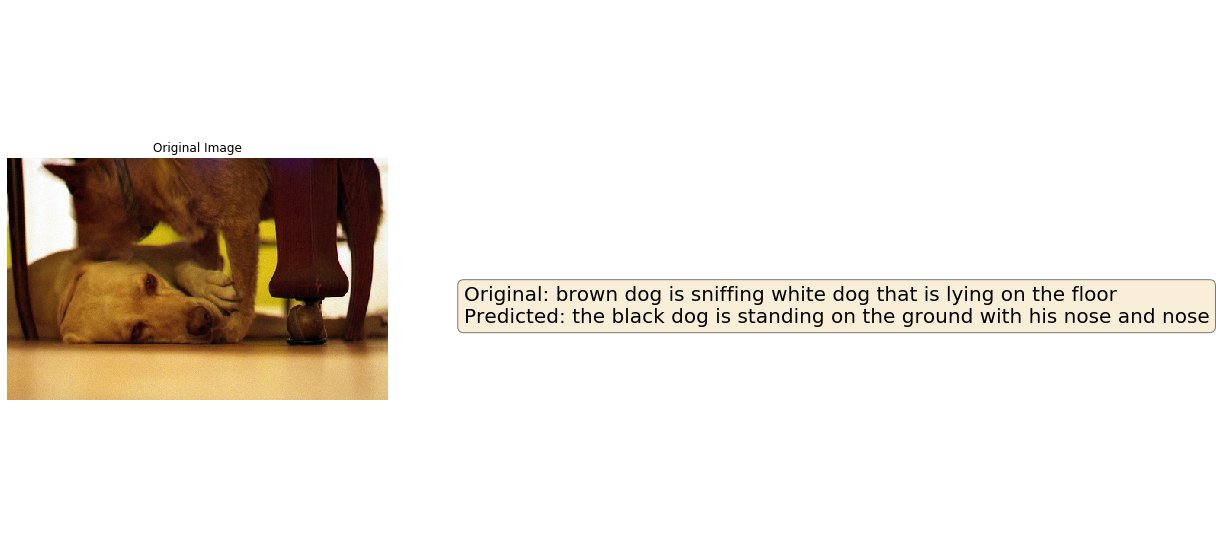

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

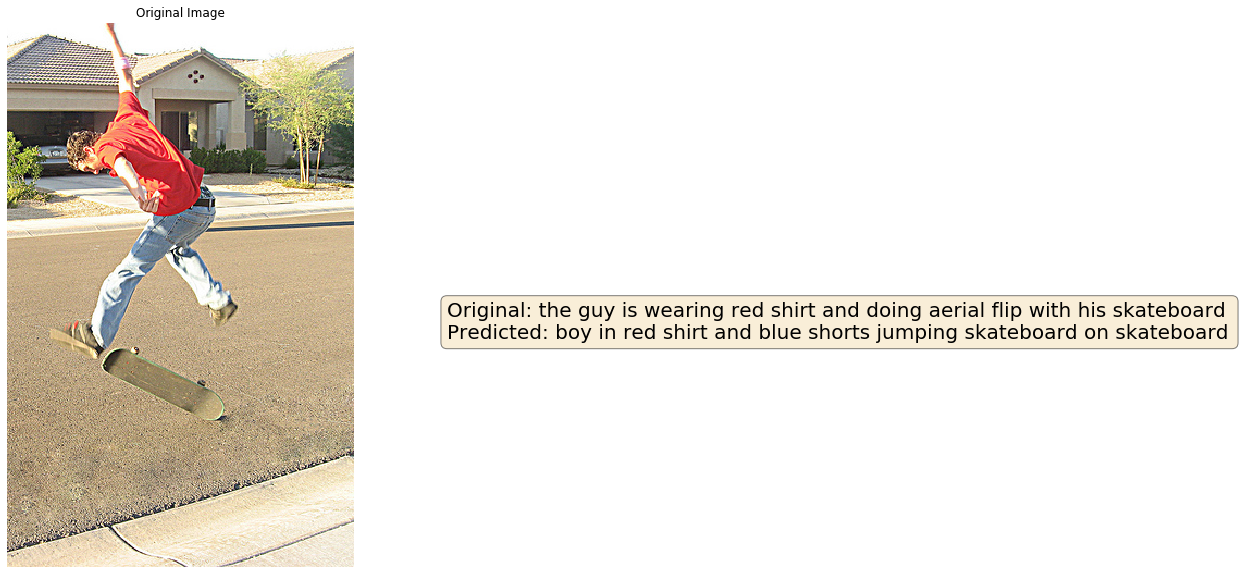

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

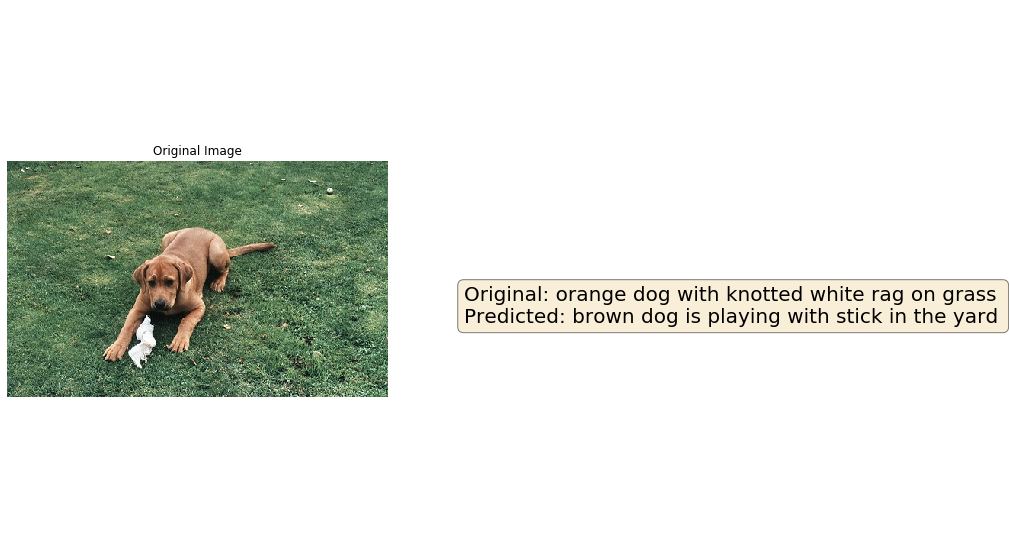

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

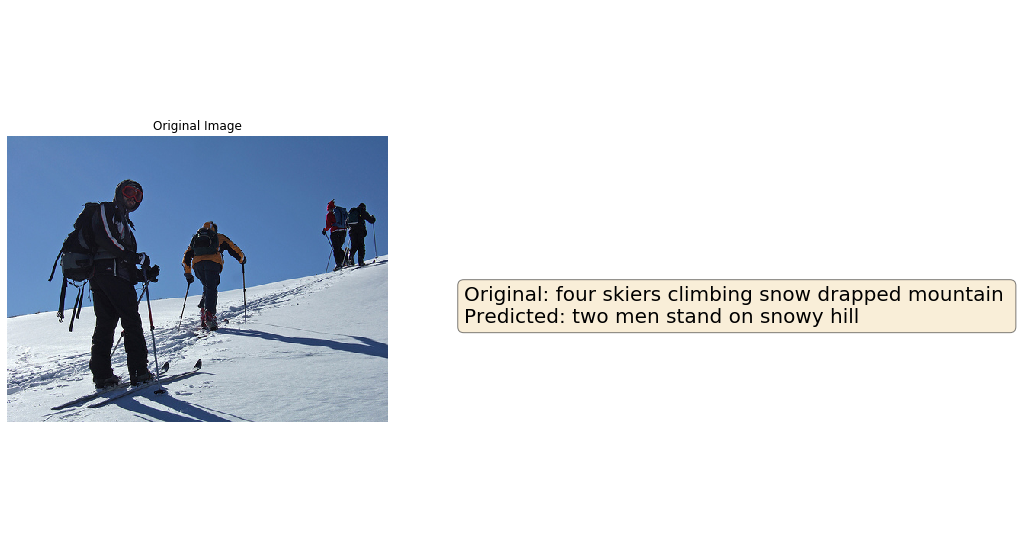

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

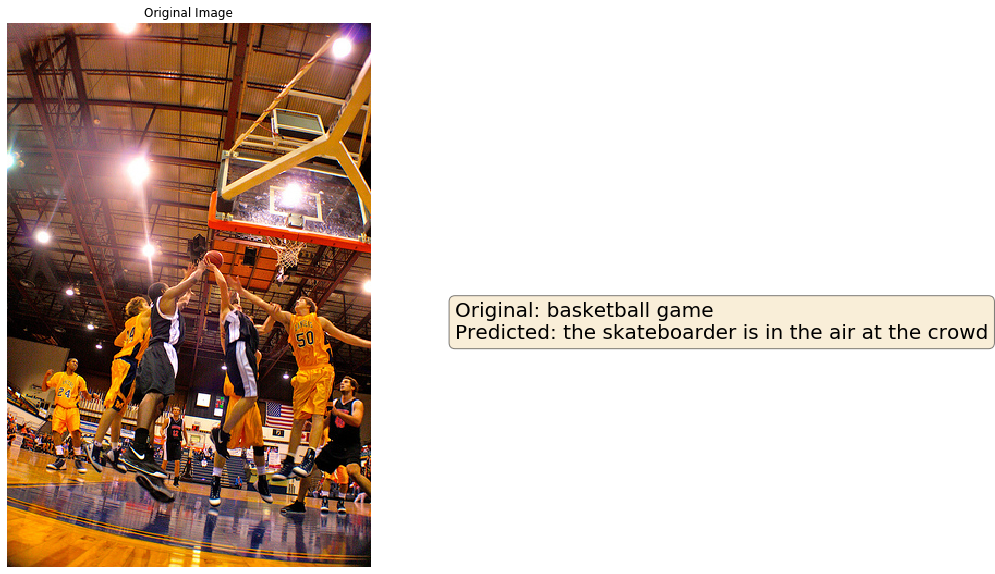

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

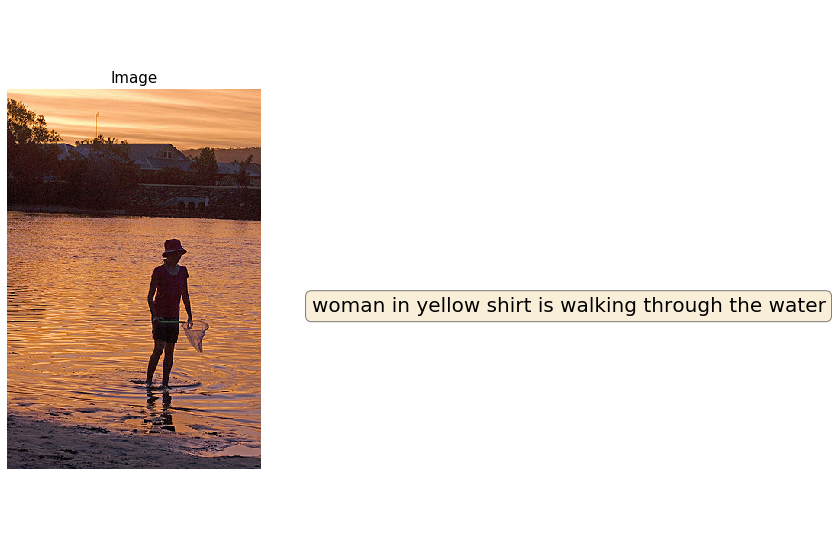

In [ ]:
# Modified only to show generated text.
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)

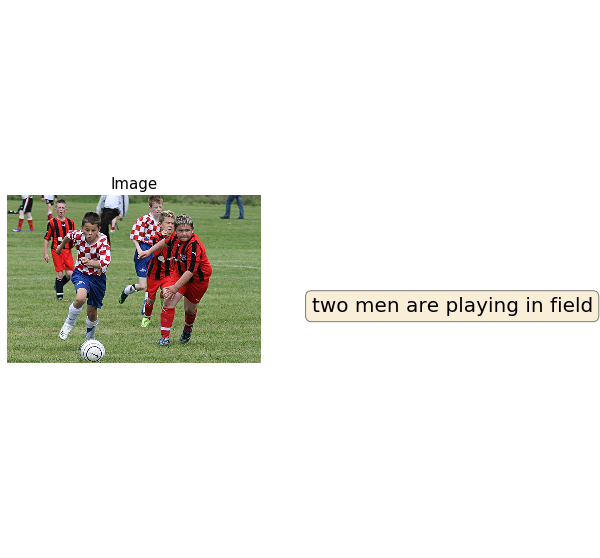

In [ ]:
view_img_caption_pair(model_path, img_abs_path, tokenizer_path)